'Frankenstein' Models in Denoising Thermodynamic Models (DTMs)

One of the remarkable facts about how these DTMs are trained is that a DTM's diffusion steps are trained completely independently—the start and end training data for each step is computed analytically using the step's start and end times (via get_perturbed_data() in step.py). This surprising fact raises the question: what would happen if you pieced together steps from different stages in the model's training?

The loading facilities in DTM.py allow for testing these models by optionally loading steps from different epochs (and even different DTMs entirely as long as configs are compatible).
These stitched models, which I cheekily call frankenstein models because they are made by sewing together diffusion steps from different stages of training, will be the focus of this notebook, with the hope that their performance offers some insight on what each diffusion step does. 

In case you intend on playing around with this code, with my setup I've found exporting the notebook to a py script and running there is significantly faster than running in the ipynb. Now let's get some imports out of the way:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax.random as jr
from thrmlDenoising.DTM import DTM
from thrmlDenoising.utils import make_cfg
from thrmlDenoising.smoke_testing import compute_conditional_accuracy, compute_free_accuracy

Now we will define the config for the DTM we will be using for this notebook. We use the smoke_testing dataset and utilities instead of MNIST for ease of running locally.

In [3]:
def smoke_cfg(seed, descriptor, num_steps=4):
    return make_cfg(
        exp=dict(seed=seed, descriptor=descriptor, compute_autocorr=False, generate_gif=False),
        data=dict(dataset_name="smoke_testing_2_2_2"),
        graph=dict(graph_preset_architecture=6_4, num_label_spots=2, grayscale_levels=2, torus=False),
        sampling=dict(n_samples=10, steps_per_sample=5, steps_warmup=40, training_beta=1.0),
        generation=dict(generation_beta_start=0.8, generation_beta_end=1.2, steps_warmup=60, fid_images_per_digit=50),
        diffusion_schedule=dict(num_diffusion_steps=num_steps, kind="log", diffusion_offset=0.1),
        diffusion_rates=dict(image_rate=0.8, label_rate=0.2),
        optim=dict(momentum=0.9, b2_adam=0.999, step_learning_rates=(0.1,), n_epochs_for_lrd=10),
        cp=dict(adaptive_cp=False),
    ) # target classes and batch size are automatically handled for smoke testing
n_epochs = 150
evaluate_every = n_epochs // 3
# Train a single DTM, saving checkpoints along the way
cfg = smoke_cfg(1, "smoke_frank")
dtm = DTM(cfg)
dtm.train(n_epochs, evaluate_every=evaluate_every)

Configuration:
{ 'cp': { 'adaptive_cp': False,
          'adaptive_threshold': 0.016,
          'correlation_penalty': (0.0,),
          'cp_min': 0.001},
  'data': { 'dataset_name': 'smoke_testing_2_2_2',
            'pixel_threshold_for_single_trials': 0.1,
            'target_classes': (0, 1, 2, 3)},
  'diffusion_rates': {'image_rate': 0.8, 'label_rate': 0.2},
  'diffusion_schedule': { 'diffusion_offset': 0.1,
                          'kind': 'log',
                          'num_diffusion_steps': 4},
  'exp': { 'animated_images_per_digit': 2,
           'compute_autocorr': False,
           'descriptor': 'smoke_frank',
           'drawn_images_per_digit': 4,
           'generate_gif': False,
           'graph_seeds': (1, 2, 3, 4),
           'n_cores': 1,
           'seed': 1,
           'steps_per_sample_in_gif': 10},
  'generation': { 'fid_images_per_digit': 50,
                  'generation_beta_end': 1.2,
                  'generation_beta_start': 0.8,
                  'steps

Now we define some helper functions for evaluating all frankenstein models possible from the saved models, and show the performance of each of these models. (For smoke test data sets, the conditional performance we use is the percentage of the generated images that exactly match the image pixel values set in smoke_test_data_dict in smoke_testing.py)

In [4]:
eval_key = jr.PRNGKey(42)

def eval_franken(dtm):
    cond_acc = compute_conditional_accuracy(dtm, eval_key, batch_size=40, n_print=None)
    return cond_acc

# Get list of saved epochs
epochs = list(range(0, n_epochs + 1, evaluate_every))
n = len(epochs)

save_dir = dtm.model_saving_path

# Function to evaluate all franken combos for a division
def evaluate_franken_division(early_steps: list[int], late_steps: list[int]) -> np.ndarray:
    scores = np.zeros((n, n))
    for i, early_e in enumerate(epochs):
        for j, late_e in enumerate(epochs):
            step_sources = [
                os.path.join(save_dir, f"epoch_{early_e:03d}", f"step_{s:02d}.eqx") for s in early_steps
            ] + [
                os.path.join(save_dir, f"epoch_{late_e:03d}", f"step_{s:02d}.eqx") for s in late_steps
            ]
            franken = DTM.load(base_path=save_dir, step_sources=step_sources)
            score = eval_franken(franken)
            scores[i, j] = score
    return scores

# Function to plot heatmap for a division
def plot_franken_heatmap(first_grouped_steps: list[int], second_grouped_steps: list[int]):
    scores = evaluate_franken_division(first_grouped_steps, second_grouped_steps)
    plt.imshow(scores, origin="lower", cmap="viridis")
    plt.colorbar(label="Conditional Accuracy % – higher better")
    plt.xticks(range(n), epochs)
    plt.yticks(range(n), epochs)
    early_str = ",".join(map(str, first_grouped_steps))
    late_str = ",".join(map(str, second_grouped_steps))
    plt.xlabel(f"Second Group (Steps {late_str})")
    plt.ylabel(f"First Group (Steps {early_str})")
    plt.title(f"Frankenstein: Steps {early_str} vs {late_str}")
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{scores[i, j]:.1f}", ha="center", va="center", color="black")
    plt.show()

And then we call these helpers to evaluate the model for the three natural diffusion step groupings. Two diffusion steps are in the same group if they are always trained for the same number of epochs.

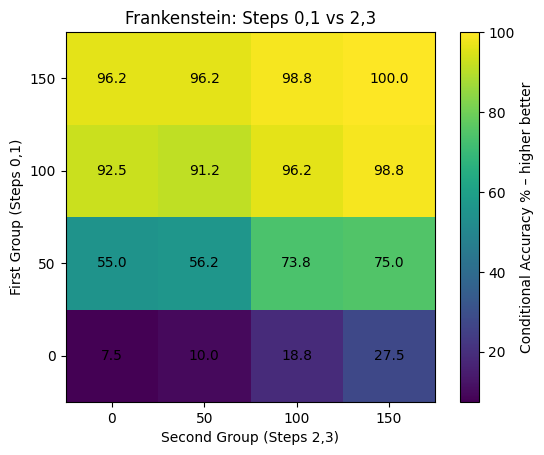

In [5]:
plot_franken_heatmap([0, 1], [2, 3])

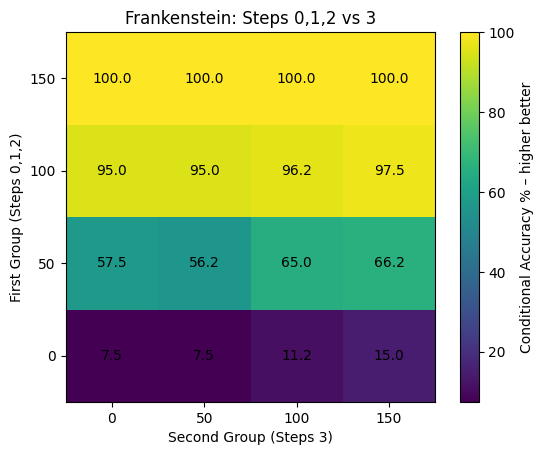

In [6]:
plot_franken_heatmap([0, 1, 2], [3])

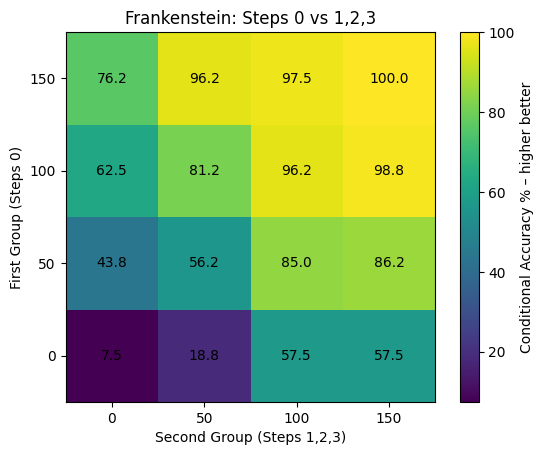

In [7]:
plot_franken_heatmap([0], [1, 2, 3])

The later steps in the denoising generation's training seem to matter more than the earlier ones, which is likely what you would expect as those steps get the last say in the denoising process- if they are completely untrained then of course handing even perfectly denoised data to them won't help (bottom rows.)

The smoke testing observations somewhat carry over for fashion mnist models. Below is a 4 step 60 side length with degree 12 frankenstein's heatmaps:

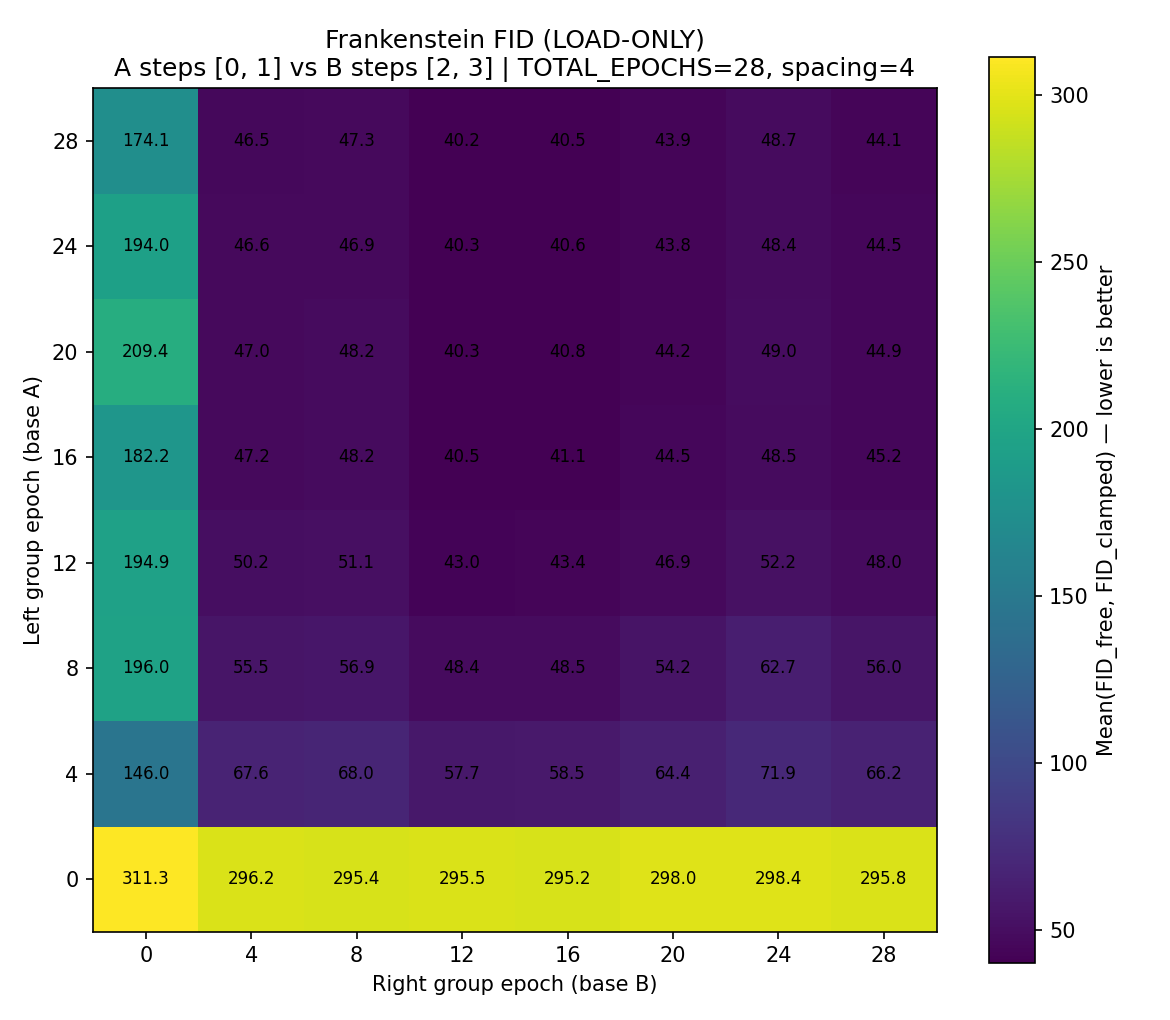

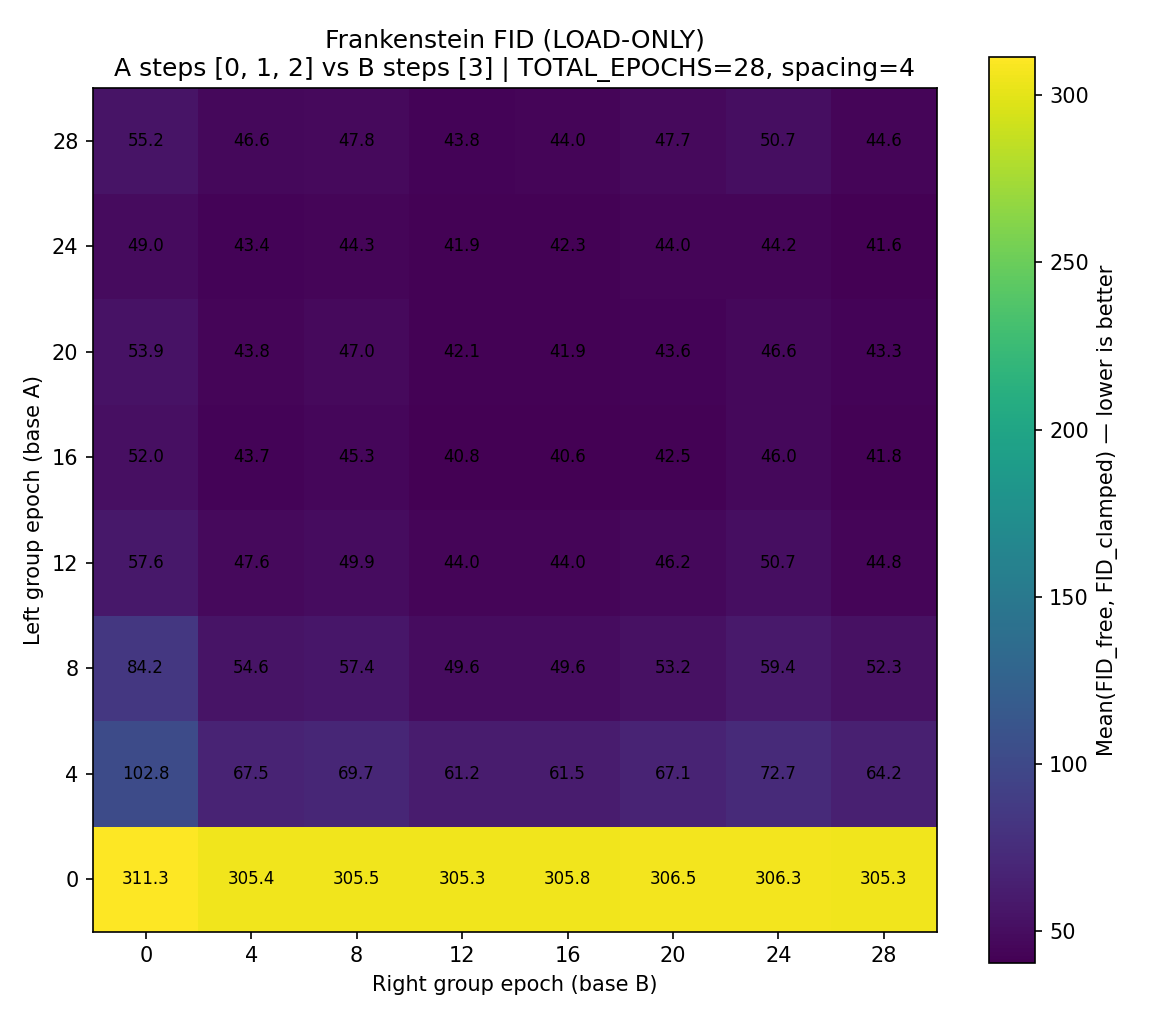

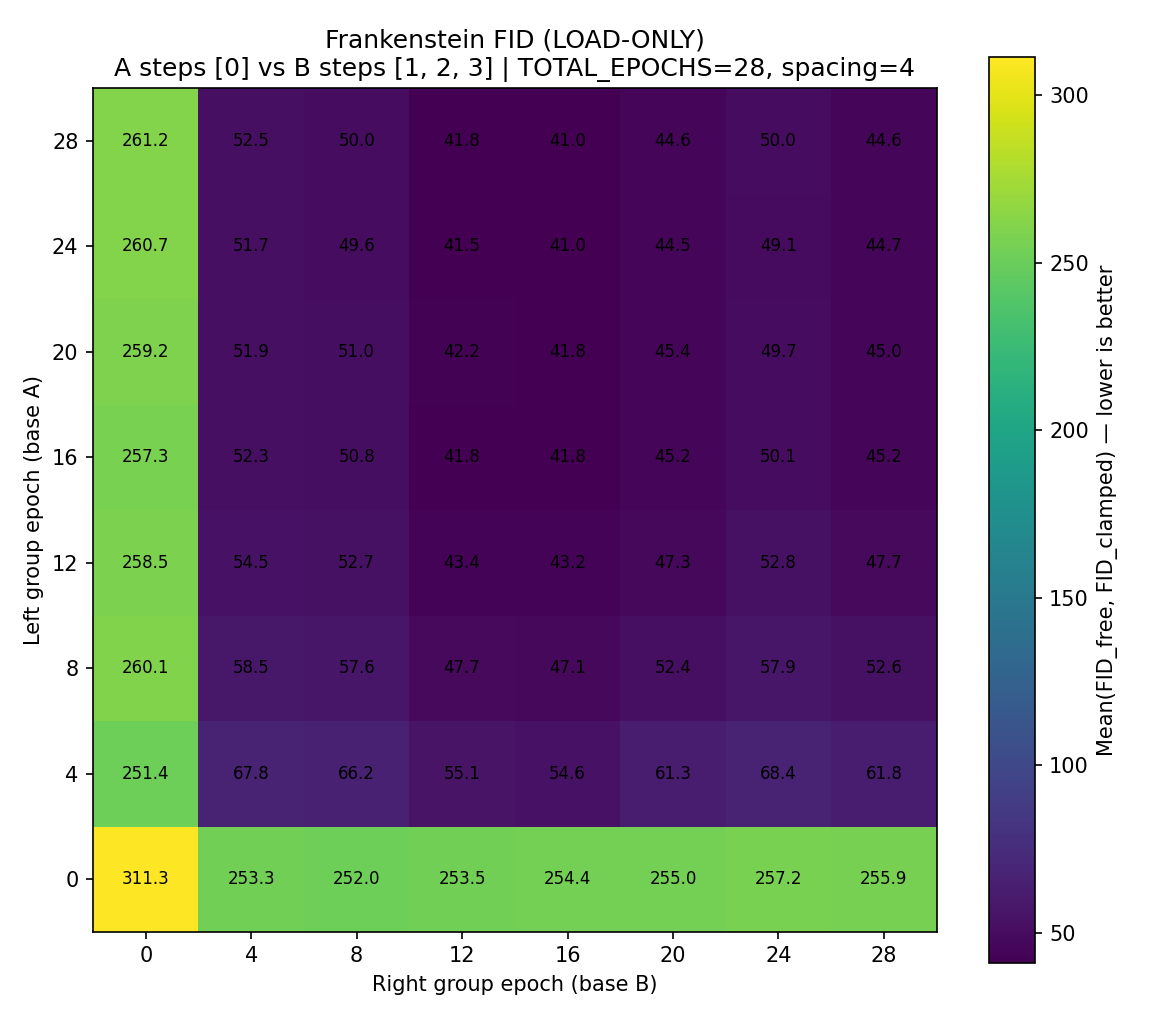

And here is a heat map of a 2 step 70 side length with degree 24 frankenstein DTM's heatmap:

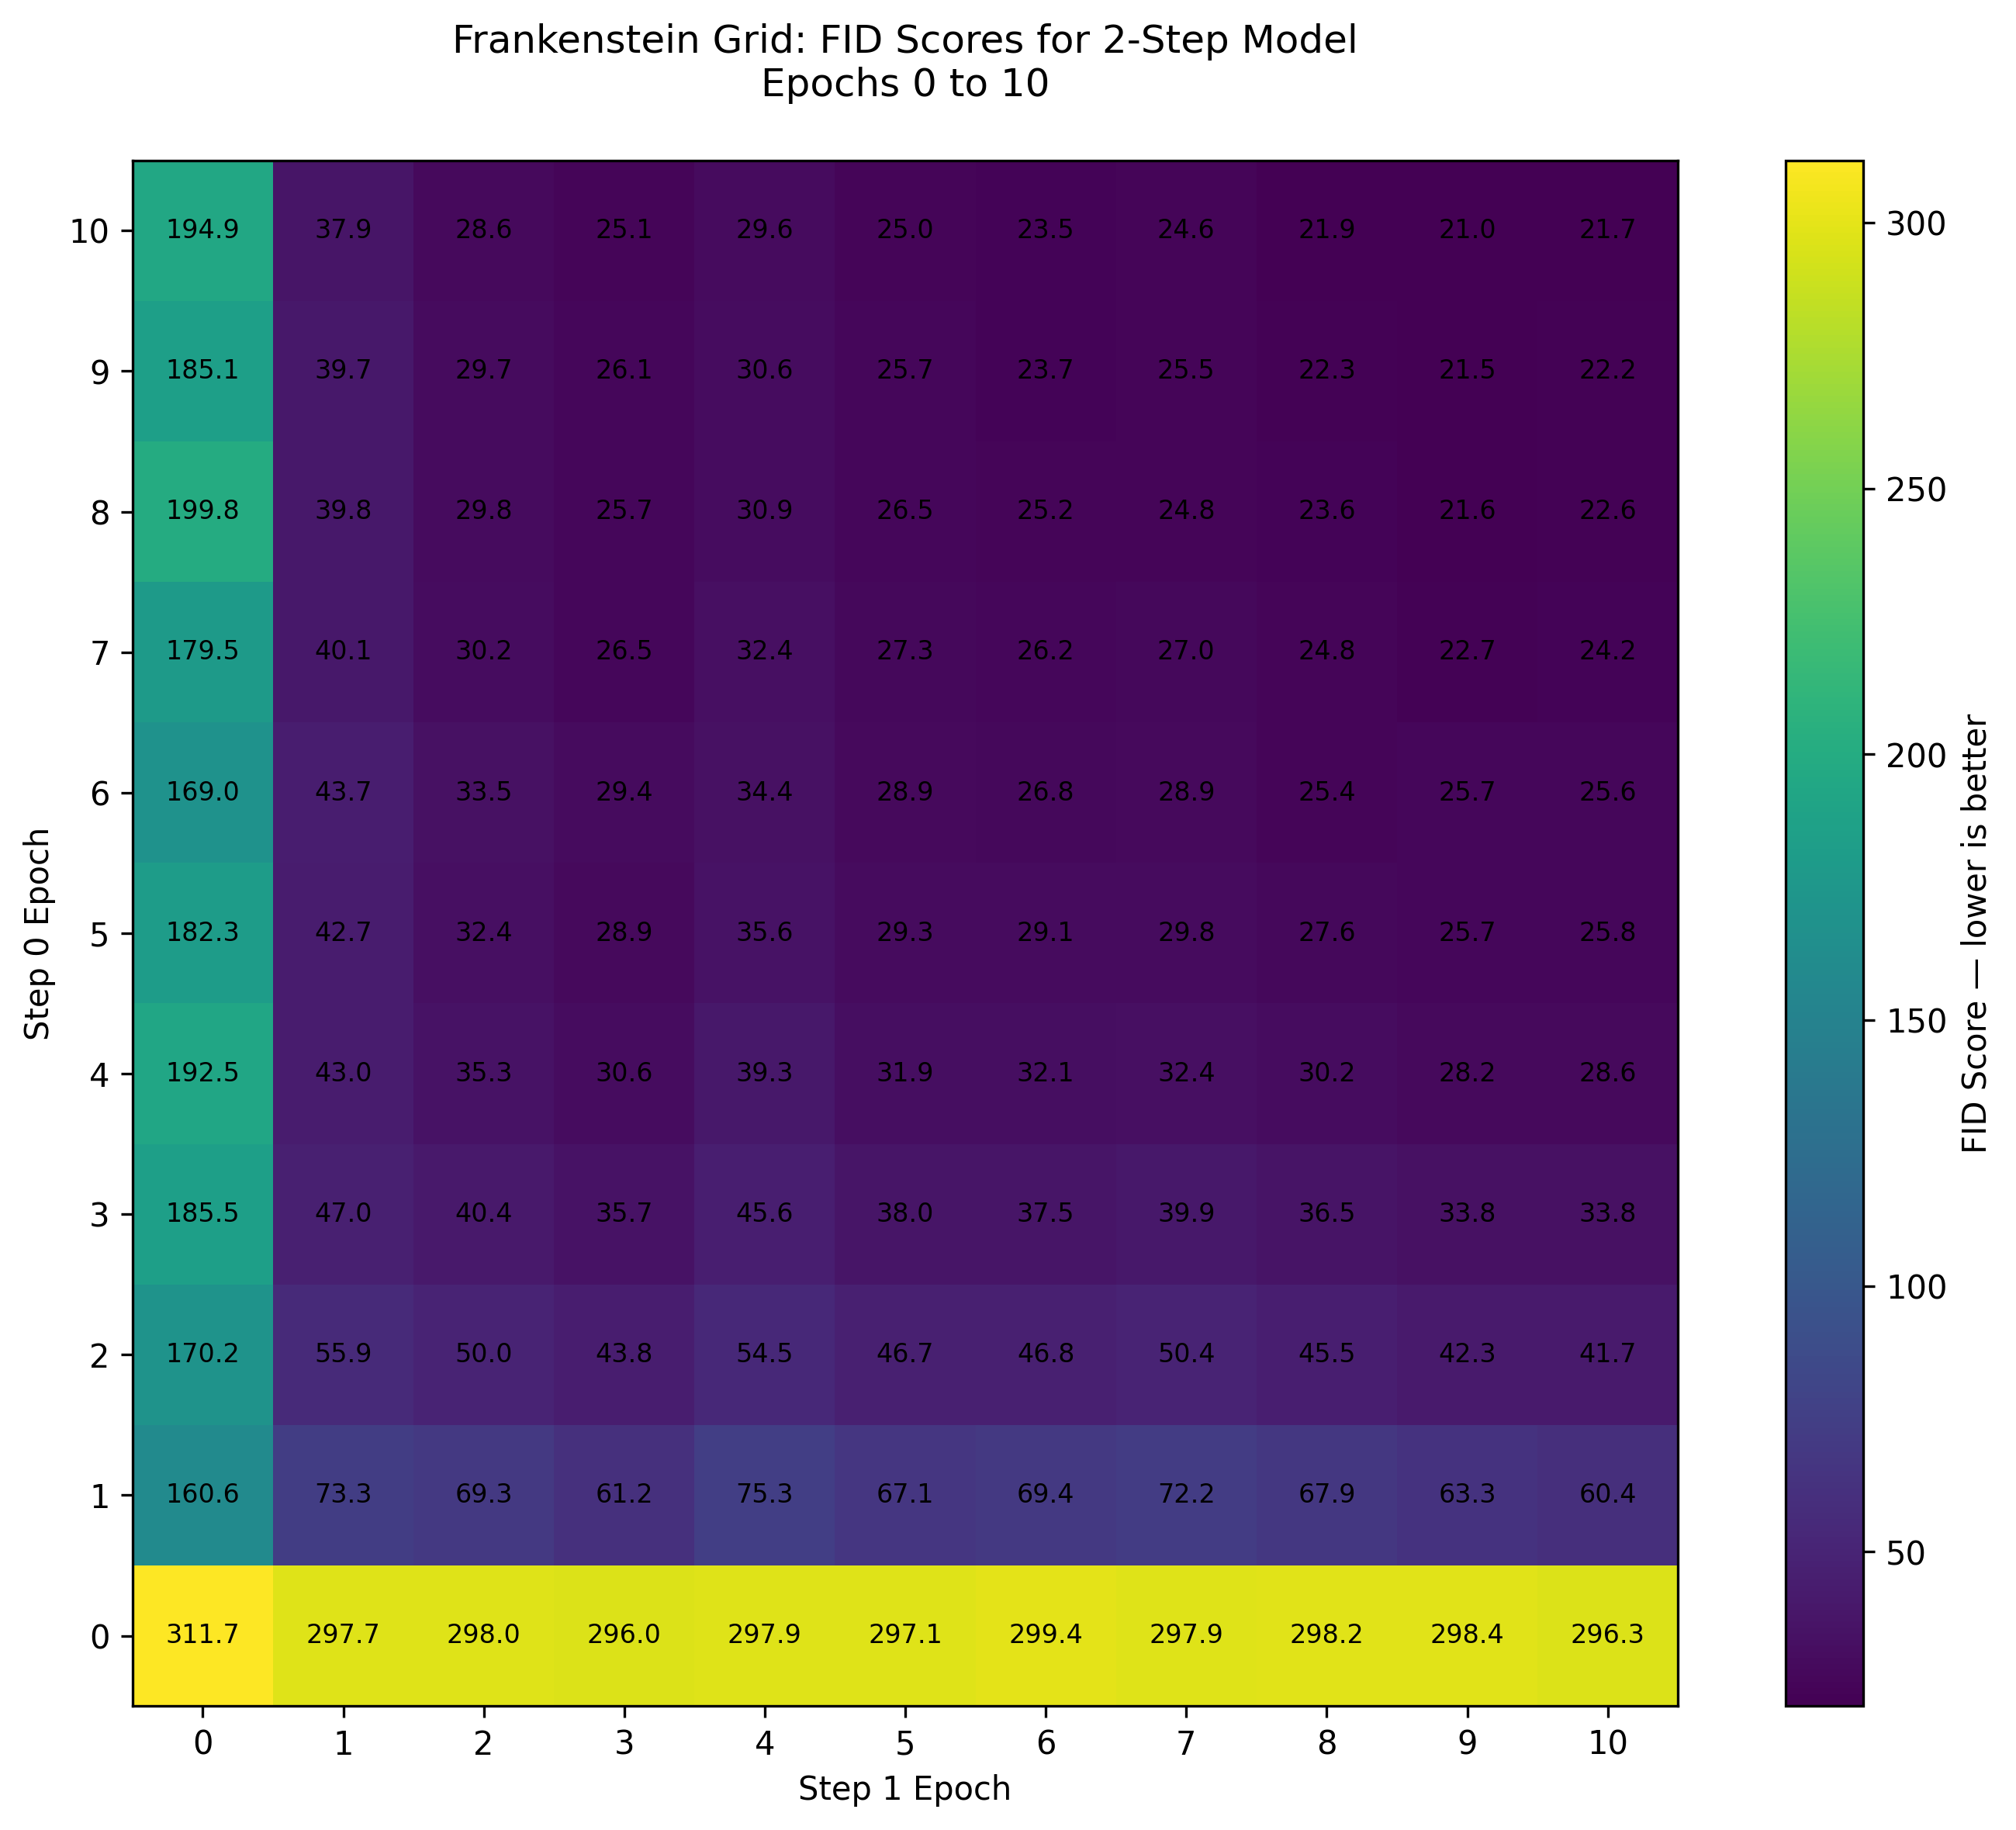